In [1]:
# https://garrrychan.github.io/blog/nba_elo.html
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'

import altair as alt
alt.renderers.enable('notebook')

from sklearn.metrics import accuracy_score, brier_score_loss
# scientific notation off
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

# blog html visualization 
from IPython.display import HTML
# supress warnings for blog
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# https://github.com/fivethirtyeight/data/tree/master/nba-elo
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-elo/nbaallelo.csv'

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-elo/nbaallelo.csv')
df.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.29,NYK,Knicks,68,1300.00,1306.72,H,L,0.64,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.71,TRH,Huskies,66,1300.00,1293.28,A,W,0.36,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.01,NYK,Knicks,47,1306.72,1297.07,H,W,0.63,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.69,CHS,Stags,63,1300.00,1309.65,A,L,0.37,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.86,WSC,Capitols,50,1300.00,1320.38,H,L,0.64,NaN


In [3]:
df.columns

Index(['gameorder', 'game_id', 'lg_id', '_iscopy', 'year_id', 'date_game',
       'seasongame', 'is_playoffs', 'team_id', 'fran_id', 'pts', 'elo_i',
       'elo_n', 'win_equiv', 'opp_id', 'opp_fran', 'opp_pts', 'opp_elo_i',
       'opp_elo_n', 'game_location', 'game_result', 'forecast', 'notes'],
      dtype='object')

In [ ]:
# Let's create a class to define a function, prob, to calculate the probability of a team winning based on elo,
# # and define another function, update, to update the Elo after the outcome of the game.

class EloTracker:
    def __init__(self, data, start=1500):
        if isinstance(data, dict):
            self.data = data
        if isinstance(data, list):
            self.data = {i: start for i in data}

    # this is the probability of the home team winning
    def prob(self, home, away):
        home_elo, away_elo = self.data[home], self.data[away]
        expected_home = 1 / ( 1 + 10**((away_elo - home_elo)/400))
        expected_away = 1 - expected_home
        return expected_home, expected_away

    # update the elo scores
    def update(self, winner, loser, k=20):
        expected_winner, expected_loser = self.prob(winner, loser)
        self.data[winner] = round(self.data[winner] + k*(1 - expected_winner))
        self.data[loser] = round(self.data[loser] + k*(0 - expected_loser))
        return self.data

    def __repr__(self):
        return f'EloTracker({self.data})'

In [ ]:
# instantiate all teams at 1500 elo at the beginning of the season
teams = ['Toronto', 'Boston']
elo = EloTracker(teams)
elo.data

In [ ]:
# By definition, teams with the same elo are equally likely to win.
elo.prob('Toronto', 'Boston')

In [ ]:
# Toronto beats Boston
# Update elo
elo.update('Toronto', 'Boston')
# Toronto gained 10 elo, and Boston lost 10, since this is a zero sum paradigm

In [ ]:
# Fast forward to the end of the season

# End of season, let's assume these elo scores
teams = {'Toronto': 1750, 'Boston': 1500, 'Cleveland': 1250}
elo = EloTracker(teams)
elo.data
toronto_elo_before = elo.data["Toronto"]
elo.update("Toronto", "Cleveland")
toronto_elo_after = elo.data["Toronto"]

print(f' Toronto gained {toronto_elo_after - toronto_elo_before} elo points')
# Because Toronto won against a worst team, they only gained 1 elo points.

In [ ]:
# Toronto is favoured since it has a higher elo score. 
# But, what if Toronto lost?
teams = {'Toronto': 1750, 'Boston': 1500, 'Cleveland': 1250}
elo = EloTracker(teams)
elo.data
toronto_elo_before = elo.data["Toronto"]
elo.update("Cleveland","Toronto")
toronto_elo_after = elo.data["Toronto"]

print(f' Toronto gained {toronto_elo_after - toronto_elo_before} elo points')
# Because Toronto lost to a worse team, they lost 19 elo points! They were expected to win!

In [5]:
# 2014-2015, regular season, home games only, no duplicate record
df = df.query("year_id==2015 & is_playoffs == 0 & _iscopy == 0")

# obtain columns of interest
df = df[['date_game','fran_id', 'pts', 'elo_i', 'opp_fran', 'opp_pts', 'opp_elo_i', 'game_result']].reset_index()

# rename columns
df = df.rename(columns={
    'date_game':'date',
    "fran_id":"home",
    "pts": "pts_home",
    "elo_i": "home_elo",
    "opp_fran":"visitor",
    "opp_pts":"pts_visitor",
    "opp_elo_i":"visitor_elo",
})

df["winner"] = df.apply(lambda row: row.home if row.game_result == "W" else row.visitor, axis=1)

df = df.drop(["index","game_result"],axis=1)

df['date'] = pd.to_datetime(df['date'])
# 1230 games played in 2014-2015
# 30 teams played x 41 home games each 

In [8]:
HTML(df.head().to_html(classes="table table-responsive table-striped table-bordered"))

,date,home,pts_home,home_elo,visitor,pts_visitor,visitor_elo,winner
0,2014-10-28,Lakers,90,1422.00,Rockets,108,1596.46,Rockets
1,2014-10-28,Pelicans,101,1457.22,Magic,84,1359.43,Pelicans
2,2014-10-28,Spurs,101,1699.50,Mavericks,100,1592.01,Spurs
3,2014-10-29,Celtics,121,1378.55,Nets,105,1518.27,Celtics
4,2014-10-29,Hornets,108,1511.00,Bucks,106,1317.85,Hornets


In [9]:
df.home.unique()

array(['Lakers', 'Pelicans', 'Spurs', 'Celtics', 'Hornets', 'Nuggets',
       'Pacers', 'Grizzlies', 'Heat', 'Knicks', 'Suns', 'Trailblazers',
       'Kings', 'Raptors', 'Jazz', 'Cavaliers', 'Mavericks', 'Clippers',
       'Timberwolves', 'Magic', 'Bulls', 'Bucks', 'Hawks', 'Pistons',
       'Warriors', 'Rockets', 'Thunder', 'Sixers', 'Wizards', 'Nets'],
      dtype=object)

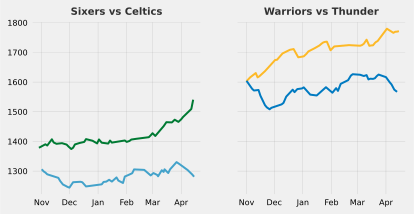

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,3),sharex=True, sharey=True)

ax[0].plot(df[df["home"]=="Sixers"].date, df[df["home"]=="Sixers"].home_elo, color='#43a2ca',linewidth=2)
ax[0].plot(df[df["home"]=="Celtics"].date, df[df["home"]=="Celtics"].home_elo, color='#007A33',linewidth=2)

ax[0].set_title("Sixers vs Celtics", color = '#000000', alpha=0.8,fontsize=10, fontweight='bold', ha = 'center') 
ax[0].tick_params(labelsize=8)

ax[1].plot(df[df["home"]=="Warriors"].date, df[df["home"]=="Warriors"].home_elo, color='#FDB927',linewidth=2)
ax[1].plot(df[df["home"]=="Thunder"].date, df[df["home"]=="Thunder"].home_elo, color='#007AC1',linewidth=2)

ax[1].set_title("Warriors vs Thunder", color = '#000000', alpha=0.8, fontsize=10, fontweight='bold', ha = 'center') 
ax[1].tick_params(labelsize=8)

ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
ax[0].xaxis.set_major_formatter(myFmt)
#plt.savefig('elo.svg')

In [12]:
# Establish Baseline
# Naive Model

y = df['winner'] # true y
y_hat = df['home'] # predict winner based on home team winning
accuracy_score(y, y_hat)

0.5747967479674797

Brier Score

$$\frac{1}{N} \sum_{i=1}^{N}(p_{i} - o_{i})^{2}$$

By definition, the Brier score measures the mean squared difference between the predicted probability $p_{i}$ assigned to the possible outcomes $o_{i}$ for all i and the actual outcome.

Mathematically, the Brier score always takes on a value between zero and one, since this is the largest possible difference between a predicted probability (which must be between zero and one) and the actual outcome (which can take on values of only 0 and 1).

Roughly speaking, the Brief score mimics a MSE for regression problems in the classification case, such as predicting binary outcomes. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated.

Like the Elo, it penalizes wrong predictions heavily when you are sure of an outcome (e.g. upsets in sports). This is not necessarily captured in accuracy, so it is a good supplement metric when evaluating models.

In other words, it calibrates the predictions. You predicted that good teams when they SHOULD win, and predicted that losses when they SHOULD lose. When you were unsure, it SHOULD be a coin toss! That is a good model.

In [13]:
# Naive Model: Brier Score
# To calculate the Brier score we need the true probabilities and the predicted probabilities

# true y
# 100% for correct prediction
# 0% for incorrect prediction
df["y"] = df.apply(lambda row: 1 if row.home == row.winner else 0,axis=1)
y = df["y"]

# y_prob is the probability of winning for home team 
# probability of winning is 100% if you're home and if you're 0% away
df['predict_home_win'] = np.ones(len(y))
y_prob = df.predict_home_win

brier_score_loss(y, y_prob, pos_label=1)

0.42520325203252035

In [14]:
# Elo Model
# What if we tried to be smarter? Are we able to create a model with Elo that is more accurate?

# calculate the probability of winning for the home team using elo
def prob(home_elo, away_elo):
    expected_home = 1 / ( 1 + 10**((away_elo - home_elo)/400) )
    expected_away = 1 - expected_home
    return expected_home, expected_away

df['predict_home_elo_win'] = df.apply(lambda row: prob(row.home_elo, row.visitor_elo)[0], axis=1)
# predict home win if % is greater than 50%
df['predict_elo'] = np.where(df.predict_home_elo_win >= 0.5, df.home, df.visitor)
y = df['winner'] # true y
y_hat = df.predict_elo  # predict winner based on home team winning
y_prob = df.predict_home_elo_win # probability of home team winning
accuracy_score(y, y_hat)
# so, predicting on elo, is 67% accurate! This is already better than only predicting the home team.

0.6707317073170732

In [15]:
# Elo Model: Brier Score
# To calculate the Brier score we need the true probabilities and the predicted probabilities
# true y
y = df["y"]

# y_prob is the probability of winning for home team
y_prob = df["predict_home_elo_win"]

brier_score_loss(y, y_prob, pos_label=1) 

0.21094193773599698

21.09%


In [20]:
pd.DataFrame({
    'Metric': ['Accuracy', 'Brier Score'],
    'Prediction based on Home': [f'{0.5747967479674797:.2%}', f'{0.42520325203252035:.2%}'],
    'Prediction based on Elo': [f'{0.6707317073170732:.2%}', f'{brier_score_loss(y, y_prob, pos_label=1):.2%}'],
    'Delta': ['9%', '22%']
})

# Not only was the Elo model more accurate than naive model, it has a lower brier score, which suggests its predictions were better forecast.
# In this particular dataset, accuracy was able to pick up the model improvement, but when I used on a different data set (e.g. NHL), this was not the case.
# # Brier score is able to pick up improvements that may otherwise be masked.

#Along side typical metrics such as accuracy, and area under the curve, now you can be armed with another tool to evaluate your models!

,Metric,Prediction based on Home,Prediction based on Elo,Delta
0,Accuracy,57.48%,67.07%,9%
1,Brier Score,42.52%,21.09%,22%


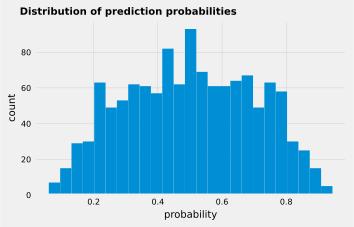

In [21]:
# Margin of Safety & NBA Upsets

plt.figure(figsize = (5,3))
plt.title("Distribution of prediction probabilities", fontsize=10, fontweight="bold", position = (0.3,1))
plt.hist(df.predict_home_elo_win, bins=25);
plt.xlabel('probability', fontsize=10)
plt.ylabel('count', fontsize=10)
plt.tick_params(labelsize=8)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# win probabilities are distributed about 50% but more parity than I expected

In [22]:
margin_of_safety = df[df.predict_home_elo_win > 0.70]
HTML(margin_of_safety.head().to_html(classes="table table-responsive table-striped table-bordered"))

,date,home,pts_home,home_elo,visitor,pts_visitor,visitor_elo,winner,y,predict_home_win,predict_home_elo_win,predict_elo
4,2014-10-29,Hornets,108,1511.00,Bucks,106,1317.85,Hornets,1,1.00,0.75,Hornets
6,2014-10-29,Pacers,103,1532.67,Sixers,91,1316.42,Pacers,1,1.00,0.78,Pacers
10,2014-10-29,Suns,119,1560.12,Lakers,99,1410.66,Suns,1,1.00,0.70,Suns
16,2014-10-30,Mavericks,120,1590.40,Jazz,102,1367.04,Mavericks,1,1.00,0.78,Mavericks
29,2014-11-01,Warriors,127,1602.86,Lakers,104,1400.48,Warriors,1,1.00,0.76,Warriors
